## Import Packages

1. Camera Calibration
2. Distortion Correction
3. Color & Gradient Threshold
4. Perspective Transform

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

def plot_image_array(images, titles = [], ncols = 2, nrows = -1, fig_width = 20, fig_row_height = 4.5):
    if nrows <= 0:
        nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        if idx >= (nrows * ncols):
            break
        a=fig.add_subplot(nrows, ncols, idx + 1)
        if len(img.shape) == 2:
            imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        else:
            imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        if(len(titles) >= idx):
            a.set_title(titles[idx])

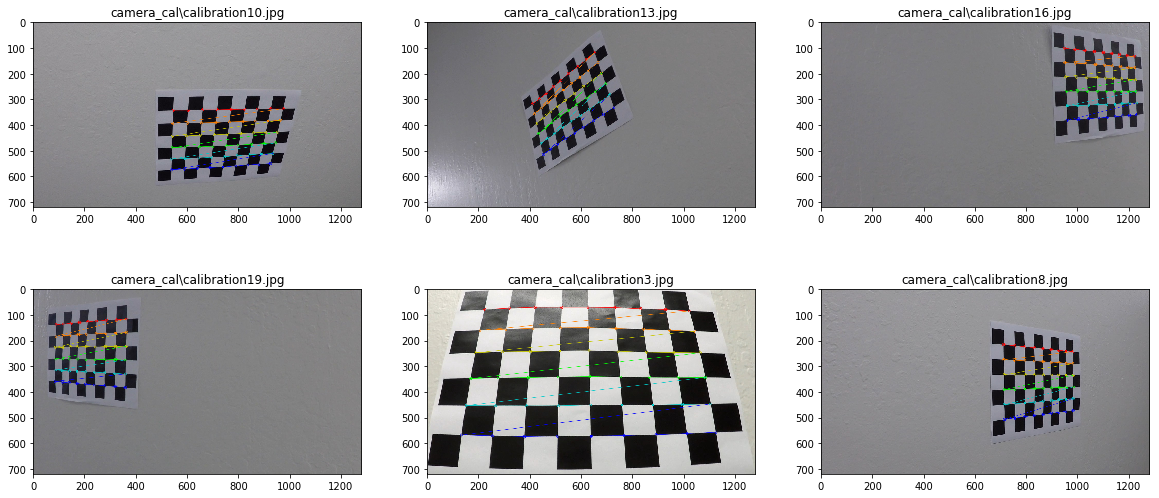

In [2]:

import cv2
import glob


n_corners = (9, 6)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_corners[0]*n_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:n_corners[0], 0:n_corners[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_files = glob.glob('camera_cal/calibration*.jpg')

chessboardImages = []
chessboardNames = []
chessboardCornerNames = []
chessboardCornerImages = []
# Step through the list and search for chessboard corners
for idx, fname in enumerate(image_files):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    chessboardImages.append(img)
    chessboardNames.append(fname)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cornerImg = img.copy()
        cv2.drawChessboardCorners(cornerImg, n_corners, corners, ret)
        chessboardCornerImages.append(cornerImg)
        chessboardCornerNames.append(fname)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)

plot_image_array(chessboardCornerImages[::3], chessboardCornerNames[::3], ncols=3, nrows=2)

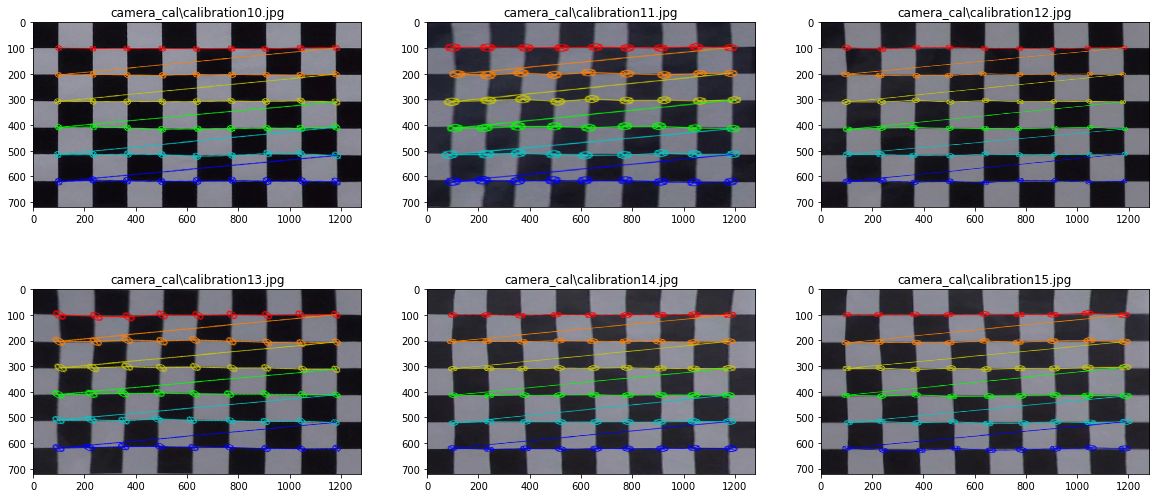

In [3]:
import pickle

img_size = (chessboardImages[0].shape[1], chessboardImages[0].shape[0])
# Do camera calibration given object points and image points
#print(objpoints)
#print(imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Make a list of calibration images
# Step through the list and search for chessboard corners
undistortedImages = []
undistortedNames = []
for idx, img in enumerate(chessboardImages):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    #undistortedImages.append(gray)
    #undistortedNames.append(chessboardNames[idx])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If corners found: 
    if ret:
        # a) draw corners
        cv2.drawChessboardCorners(undist, n_corners, corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (undist.shape[1], undist.shape[0])
        src = np.float32([corners[0], corners[n_corners[0]-1], corners[-1], corners[-n_corners[0]]])

        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])


        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        undistortedImages.append(warped)
        undistortedNames.append(chessboardNames[idx])
        
plot_image_array(undistortedImages, undistortedNames, ncols=3, nrows=2)
        
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
cam_calibration = {}
cam_calibration["mtx"] = mtx
cam_calibration["dist"] = dist
pickle.dump( cam_calibration, open( "camera_calibration.p", 'wb'))

In [185]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def combined_channel_threshold(img, channels=[0, 1, 2], thresh=[(0, 255), (0, 255), (0, 255)], color_conversion = cv2.COLOR_BGR2HLS):
    if color_conversion:
        c = cv2.cvtColor(img, color_conversion)
    else:
        c = img       
    b = []
    for channel, t in zip(channels, thresh):
        s = c[:,:,channel]
        binary_output = np.zeros(s.shape, dtype=np.uint8)
        binary_output[(s >= t[0]) & (s <= t[1])] = 1
        b.append(binary_output)
    
    return np.minimum.reduce(np.dstack(tuple(b)), axis=2)

#combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)

In [10]:
import os
import os.path

cam_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
print('Loaded camera calibration')
print('--------------------------')
print('mtx:\n', cam_calibration['mtx'])
print('\ndist:\n', cam_calibration['dist'])

def save_images(folder, images, names, binary=False):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for img, fname in zip(images, names):
        p = os.path.join(folder, fname)
        if p[:-4] != '.jpg':
            p += '.jpg'
        if binary:
            img = img * 255
        cv2.imwrite(p, img)
    
def undistort_image(img):
    return cv2.undistort(img, cam_calibration['mtx'], cam_calibration['dist'], None, cam_calibration['mtx'])

Loaded camera calibration
--------------------------
mtx:
 [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

dist:
 [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


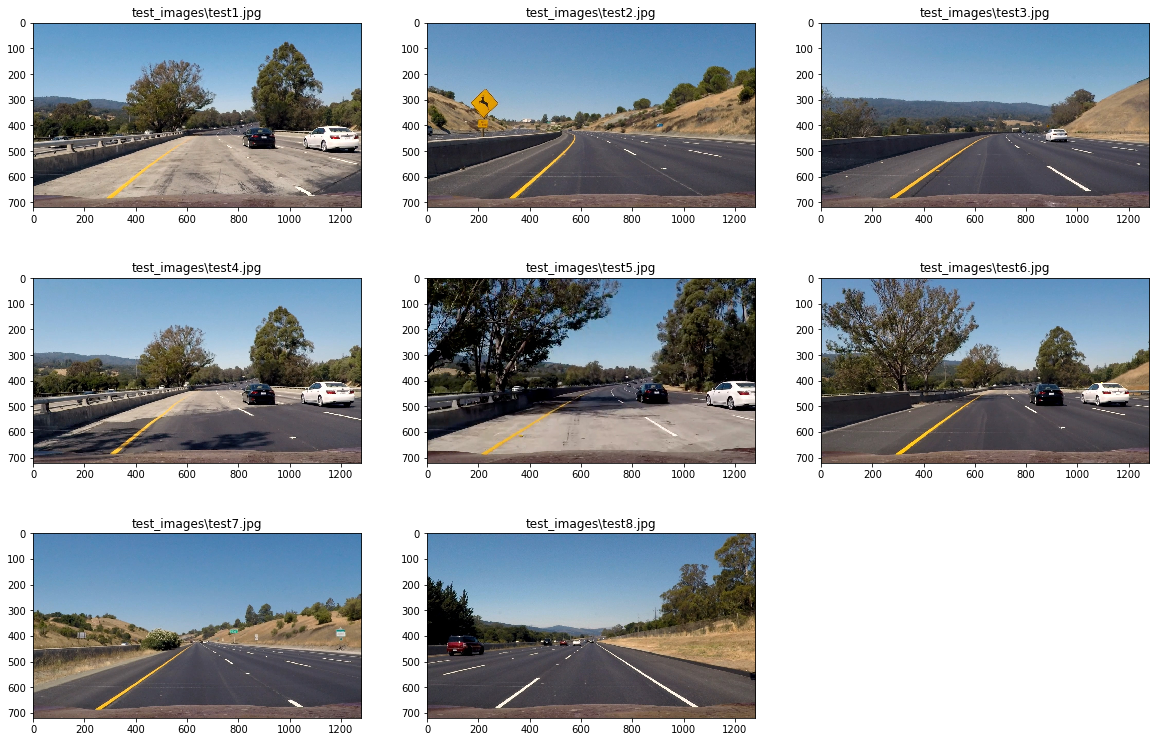

In [11]:

image_files = glob.glob('test_images/test*.jpg')

test = []
test_n = []
for idx, fname in enumerate(image_files):
    test.append(cv2.imread(fname))
    test_n.append(fname)
    
plot_image_array(test, test_n, ncols=3)   

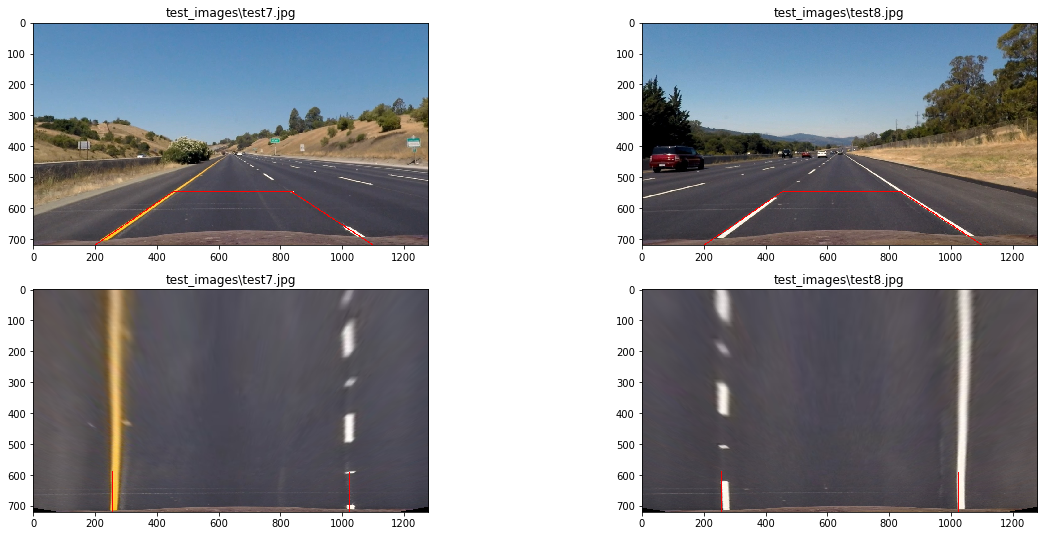

In [168]:
straight_image = test[6]
img_size = (straight_image.shape[1], straight_image.shape[0])

w,h = 1280,720
x,y = 0.6*w, 0.8*h
warp_src = np.float32([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]])
warp_dst = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0.82*h],
              [(w+x)/2.,0.82*h],
              [(w+x)/2.,h]])

#warp_src = np.float32([[585, 460],
#                      [203, 720],
#                      [1127, 720],
#                      [695, 460]])

#warp_dst = np.float32([[320, 0],
#                      [320, 720],
#                      [960, 720],
#                      [960, 0]])


M_perspective = cv2.getPerspectiveTransform(warp_src.astype(np.float32), warp_dst.astype(np.float32))

def draw_lines(src, lines, color = [0, 0, 255], thickness = 2, skip = False):
    img = src
    if len(img.shape) == 2:
        if np.max(src) <= 1:
            img = np.uint8(img.reshape((img.shape[0], img.shape[1], 1)) * 255)
            img = np.repeat(img, 3, axis=2)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    s = 2 if skip else 1
    for p in range(0, len(lines) - 1, s):
        cv2.line(img, tuple(lines[p].astype(int)), tuple(lines[p+1].astype(int)), color, thickness)
    return img
        

def warp_to_image_plane(img, M = M_perspective):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
out = []
out_n = []
for i in range(6, 8):
    c = draw_lines(undistort_image(test[i]), warp_src)
    out.append(c)
    out_n.append(test_n[i])
    
for i in range(6, 8):
    warped = warp_to_image_plane(undistort_image(test[i]), M_perspective)
    warped = draw_lines(warped, warp_dst, skip = True)
    out.append(warped)
    out_n.append(test_n[i])
    
plot_image_array(out, out_n, ncols=2)

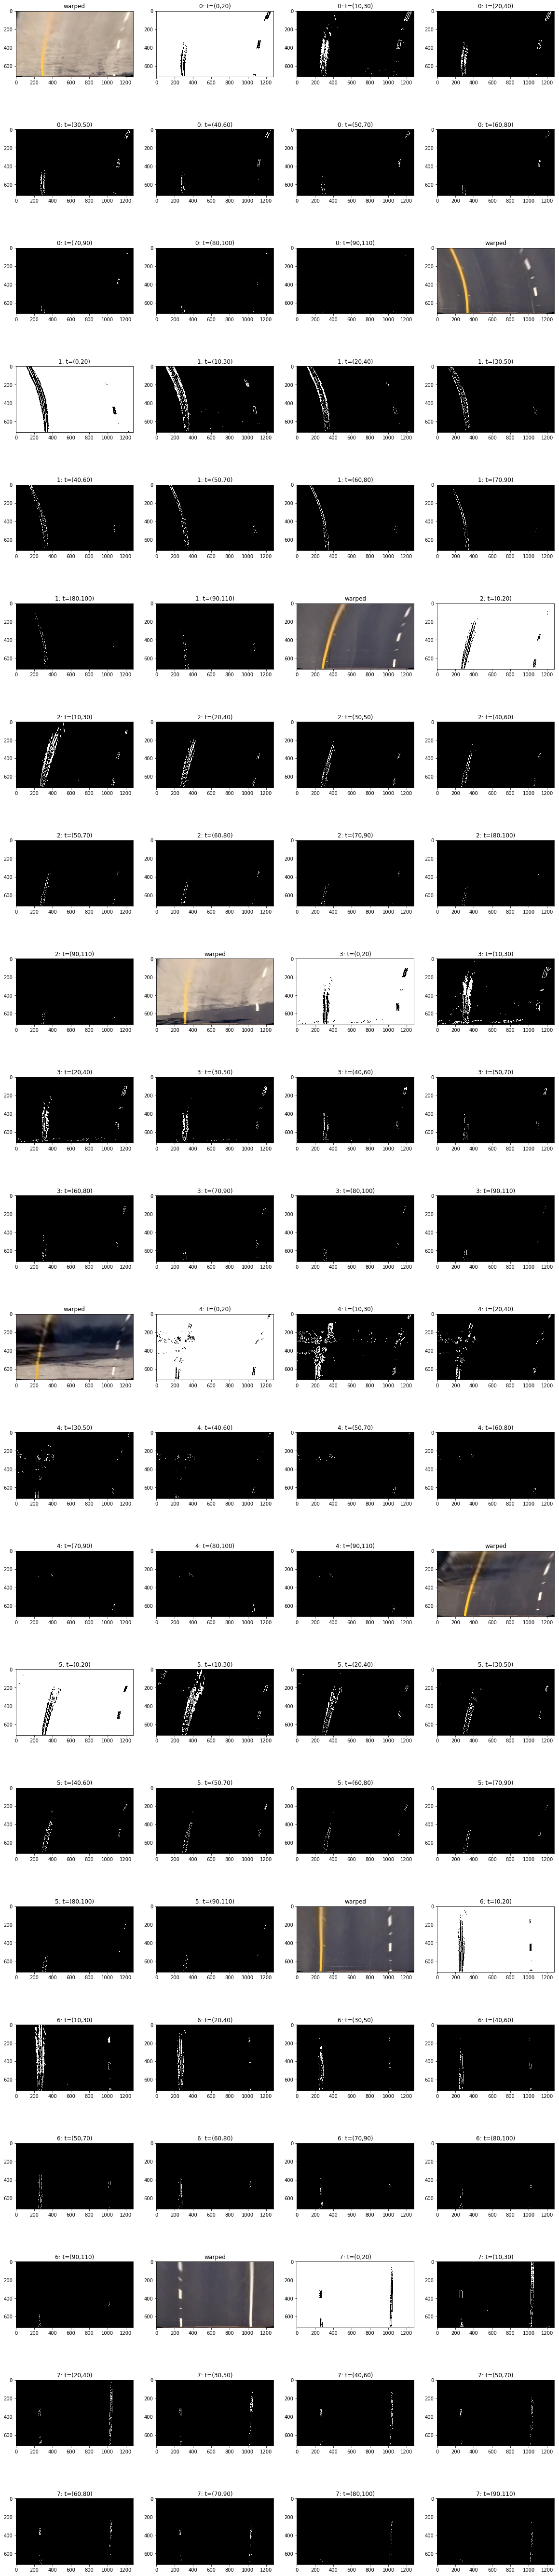

In [189]:
test_img = test[1]

# abs sobel x (5, 25, 100)
# mag thresh (9, 30, 100)
# dir sobel (15, 0.8, 1.2)
# s-channel (100, 255)
# l-channel (0, 100)


out = []
out_n = []
tmin = 0
tmax = 255
window = 20
step = 10
k = 5
i = 7
for i in range(0,8):
    #undistort image
    undistort = undistort_image(test[i])
    #out.append(undistort)
    #out_n.append(img_prefix + 'undistorted')

    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append('warped')
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    for t in range(0, 100, step):
        t1 = t + window
        binary_gx = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(t, t1))
        out.append(binary_gx)
        out_n.append("{}: t=({},{})".format(i, t, t1))


#save_images('test_images/hls/l_t', out, out_n, binary=True)
plot_image_array(out, out_n, ncols=4)   

#imgplot = plt.imshow(out[0], cmap = 'gray')

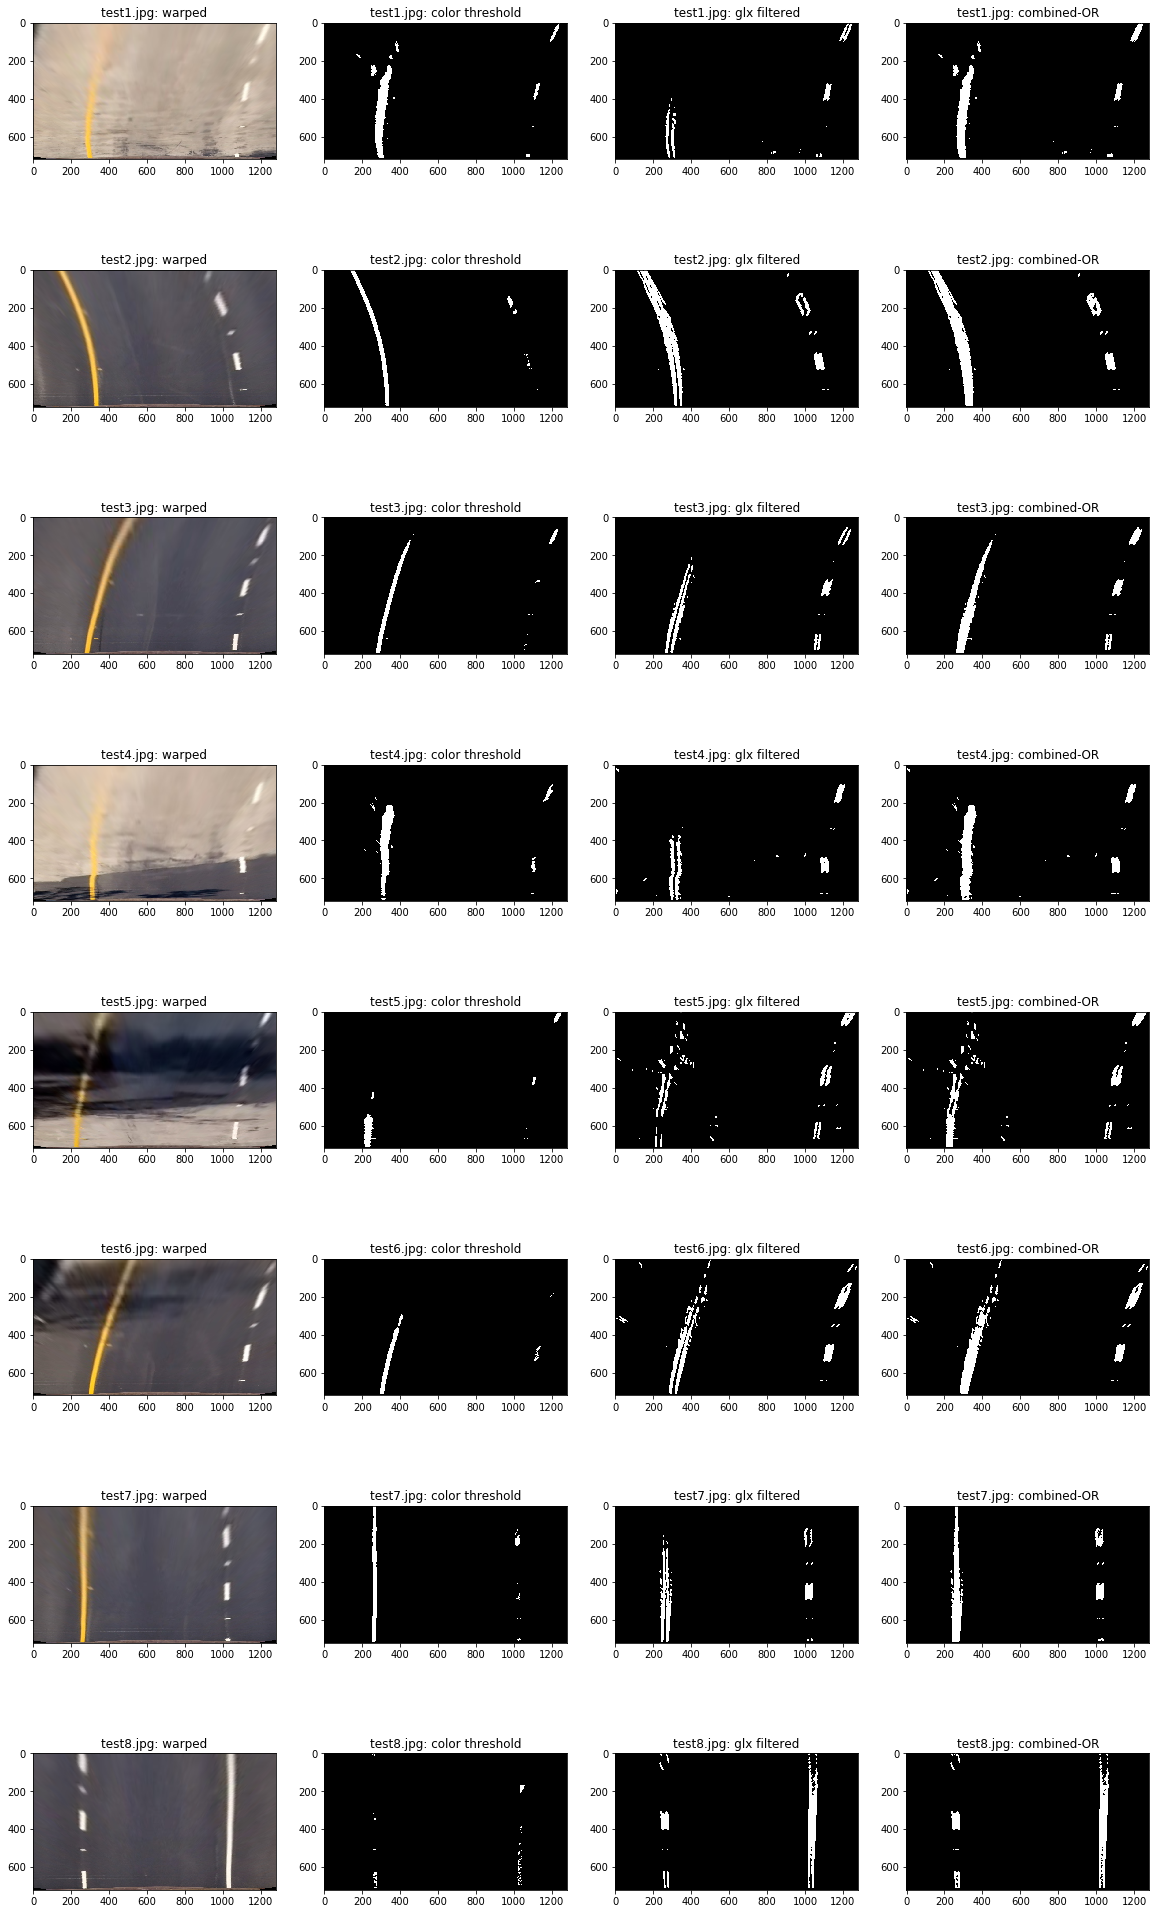

In [197]:


def process_image(img, img_name = ''):
    out = []
    out_n = []
    
    img_prefix = img_name + ': '
    
    #undistort image
    undistort = undistort_image(img)

    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append(img_prefix + 'warped')
    
    # apply color thresholds
    binary_hsv_yellow = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(0, 40), (80, 255), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)   
    binary_hsv_white = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(20, 255), (0, 80), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)

    # combine color thresholds for later demonstration
    binary_color = np.zeros_like(binary_hsv_white, dtype=np.uint8)
    binary_color[(binary_hsv_yellow == 1) | (binary_hsv_white == 1)] = 1
    out.append(binary_color)
    out_n.append(img_prefix + 'color threshold')
    
    # detect vertical lines with sobel in x-direction
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    binary_gx_l = abs_sobel_thresh(hls[:,:,1], orient='x', sobel_kernel=7, thresh=(40, 255))
    binary_gx_s = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(25, 255))
    
    # combine gradients for later demonstration
    binary_sobel = np.zeros_like(binary_gx_l, dtype=np.uint8)
    binary_sobel[(binary_gx_l == 1) | (binary_gx_s == 1)] = 1
    binary_gx_filtered = cv2.medianBlur(binary_sobel, 9) 
    out.append(binary_gx_filtered)
    out_n.append(img_prefix + 'glx filtered')  
    
    # combine all threshold images
    binary = np.zeros_like(binary_color)
    binary[(binary_color == 1) | (binary_gx_filtered == 1)] = 1
    out.append(binary)
    out_n.append(img_prefix + 'combined-OR')
    
    return binary, out, out_n

out = []
out_n = []
i=4
for i in range(len(test)):
    warped, o, o_n = process_image(test[i], img_name = os.path.split(test_n[i])[-1])
    out += o
    out_n += o_n

plot_image_array(out, out_n, ncols=4) 

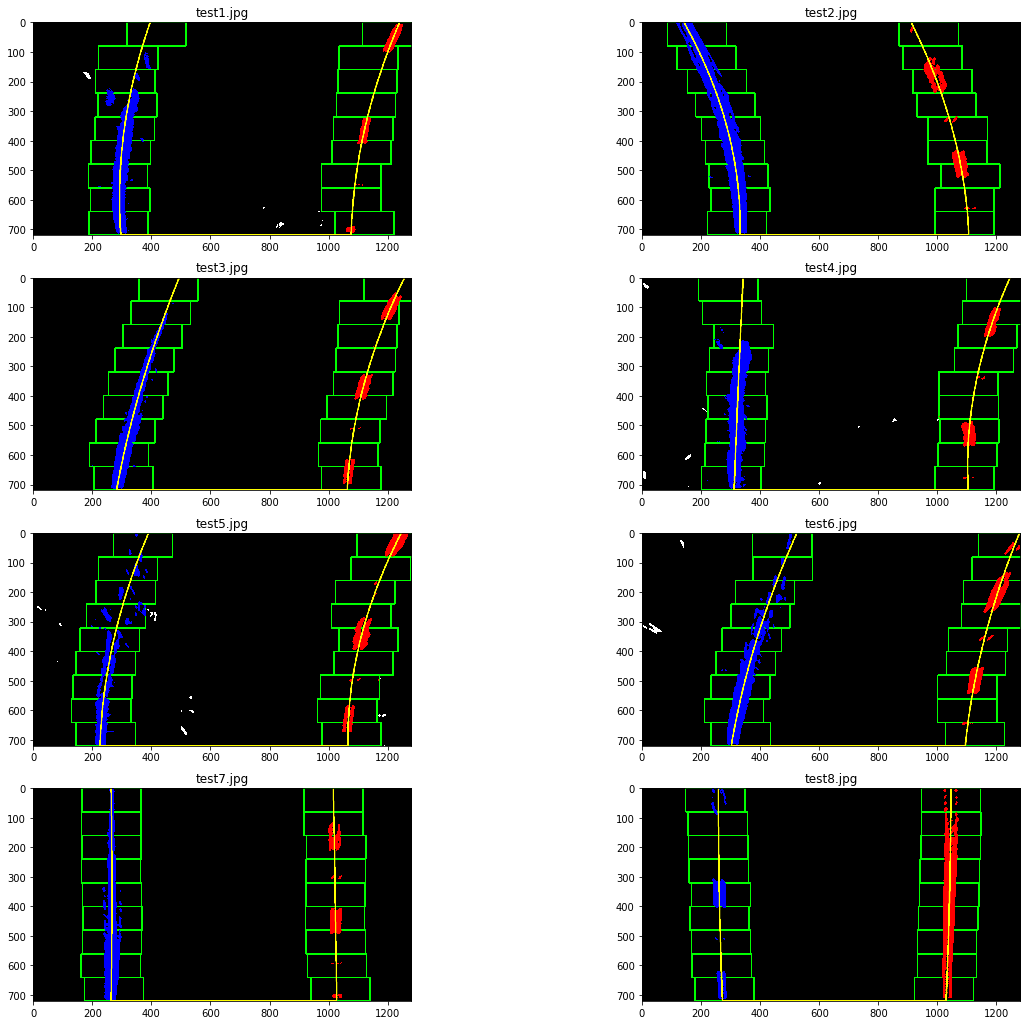

In [244]:
import operator

class SlidingWindow:

    def __init__(self, start_pos_x, image_height, n_windows = 9, window_margin = 100):
        self.window_height = np.int(image_height / n_windows)
        self.margin = window_margin
        self.image_height = image_height
        pos = []
        for p in start_pos_x:
            pos.append([(-1, p)])
        self.pos_x = tuple(pos)
        
    def set_window_x(self, level, window_index, window_pos_x):
        self.pos_x[window_index].append((level, window_pos_x))
    
    def get_window_y(self, level):
        y_high = self.image_height - level * self.window_height
        y_low = y_high - self.window_height
        return y_low, y_high
    
    def get_window_x(self, level, window_index):
        cur_lvl, cur_x = self.pos_x[window_index][-1]
        if cur_lvl > 0:
            diff = tuple(map(operator.sub, (cur_lvl, cur_x), self.pos_x[window_index][-2]))
            offset = (level - cur_lvl) * diff[1] / diff[0]
            cur_x += np.int(0.5 * offset)
        return cur_x - self.margin, cur_x + self.margin
            
def detect_lanes(binary_warped):
    histogram = np.sum(warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint    
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    n_windows = 9
    window = SlidingWindow(start_pos_x=[leftx_base, rightx_base], 
                           image_height=binary_warped.shape[0], 
                           n_windows=n_windows, 
                           window_margin=100)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for level in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low, win_y_high = window.get_window_y(level)
        win_xleft_low, win_xleft_high = window.get_window_x(level, 0)
        win_xright_low, win_xright_high = window.get_window_x(level, 1)
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            window.set_window_x(level, 0, np.int(np.mean(nonzerox[good_left_inds])))
        if len(good_right_inds) > minpix:        
            window.set_window_x(level, 1, np.int(np.mean(nonzerox[good_right_inds])))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ##########################################################################################
    #             Visualize
    ##########################################################################################

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.polylines(out_img, np.int_([pts]), False, (0,255, 255), 3, cv2.LINE_AA)
 
    return out_img
    
out = []
out_n = []
for i in range(len(test)):
    img_name = os.path.split(test_n[i])[-1]
    warped, _, _ = process_image(test[i], img_name = img_name)
    out.append(detect_lanes(warped))
    out_n.append(img_name)
    
plot_image_array(out, out_n, ncols=2) 

In [ ]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

##########################################################################################
#             Visualize
##########################################################################################

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

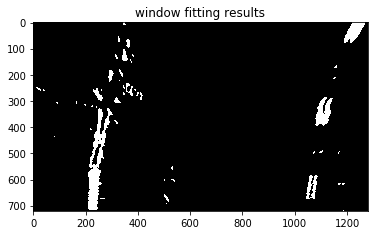

In [204]:

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer     
        window_centroids.append((l_center,r_center))
    return window_centroids

warped, _, _ = process_image(test[4], img_name = os.path.split(test_n[4])[-1])
window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    #output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    
# Display the final results
plt.imshow(warped, cmap='gray')
plt.title('window fitting results')
plt.show()

## Helper Functions
The following helper functions are taken from the template notebook and might have been modified to fit my needs (e.g. draw_lines)

In [16]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def line_angles(lines):
    """
    Calculates angles between a line and the y-axis (0 1) and the line length
    """
    angles = []
    lengths = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if(y2 < y1):
                x1, x2, y1, y2 = x2, x1, y2, y1
                
            # direction of the line    
            d = [(x2-x1), (y2-y1)]
            
            # calculate angle between line and y-axis and the line lenth 
            angle = math.acos(d[1] / np.linalg.norm(d)) * 180 / np.pi * np.sign(d[0])
            angles.append(angle)
            lengths.append(math.sqrt(np.vdot(d, d)))
            
    return angles, lengths

def expanded_angle_range(start_idx, hist, min_expand = 0):
    """
    Takes a histogram and a starting bin and expands 
    the bin ranges to surrounding bins if they exceed min_expand
    """
    # init angle range with the starting bin
    min_angle = hist[1][start_idx]
    max_angle = hist[1][start_idx + 1]
    
    # look to the 'left' for similar lines
    idx = start_idx - 1
    while idx >= 0 and hist[0][idx] > min_expand:
        min_angle = hist[1][idx]
        idx -= 1
        
    # look to the 'right' for similar lines    
    idx = start_idx + 1
    while idx < len(hist[0]) and hist[0][idx] > min_expand:
        max_angle = hist[1][idx + 1]
        idx += 1
        
    return (min_angle, max_angle)

def lane_angle_ranges(lines, angles, lengths, bins = 18):
    """
    extracts min and max angles for both lanes
    
    Uses a histogram of the line angles that is split in the middle for left and right
    lane (obviously this is not optimal). It uses the maxima of the histograms and expands 
    the ranges around them
    """
    
    lane_bins = int(bins * 0.5)
    
    # create a histogram of the line angles weighted by their lengths and 
    # split it int he middle for left and right lane
    hist = np.histogram(angles, bins, (-90, 90), weights=lengths)
    left_hist = [hist[0][:lane_bins], hist[1][:lane_bins+1]]
    right_hist = [hist[0][lane_bins:], hist[1][lane_bins:]]
 
    # expand the angle ranges around the maxima
    return [expanded_angle_range(np.argsort(left_hist[0])[-1], left_hist), \
            expanded_angle_range(np.argsort(right_hist[0])[-1], right_hist)]

def draw_lines(img, lines, colors=[[255, 0, 0], [0, 255, 0], [0, 0, 255]], thickness=2):
    """
    detects lanes and colors all lines different dependeing whether they belong to left, right or no lane
    """
    angles, lengths = line_angles(lines)
    lane_ranges = lane_angle_ranges(lines, angles, lengths)
    
    for idx, angle in enumerate(angles):
        [[x1, y1, x2, y2]] = lines[idx]
        color = colors[2]
        if lane_ranges[0][0] <= angle <= lane_ranges[0][1]: #left lane
            color = colors[0]
        elif lane_ranges[1][0] <= angle <= lane_ranges[1][1]: #right lane
            color = colors[1]
                 
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def draw_lanes(img, lines, color=[255, 0, 0], thickness=10):
    """
    detect draw an extrapolated line for each lane
    
    Lines are split into 2 groups accoring to their angle between line direction and y-axis.
    The extrapolated lanes are calculated using linear regression of their line end-points.
    """
    
    # calculate lane angle ranges to differentiate between left and right lane
    angles, lengths = line_angles(lines)
    lane_ranges = lane_angle_ranges(lines, angles, lengths)
    
    left_lane_x = []
    left_lane_y = []
    right_lane_x = []
    right_lane_y = []
    # iterate over all lines and split left and right line end-points
    for idx, angle in enumerate(angles):
        [[x1, y1, x2, y2]] = lines[idx]
        if lane_ranges[0][0] <= angle <= lane_ranges[0][1]: #left lane
            left_lane_x.append(x1)
            left_lane_x.append(x2)
            left_lane_y.append(y1)
            left_lane_y.append(y2)
        elif lane_ranges[1][0] <= angle <= lane_ranges[1][1]: #right lane
            right_lane_x.append(x1)
            right_lane_x.append(x2)
            right_lane_y.append(y1)
            right_lane_y.append(y2)
    
    if len(left_lane_x) == 0:
        raise ValueError('left lane not detected')
    elif len(right_lane_x) == 0:
        raise ValueError('right lane not detected')
     
    # linear regression to a function of y
    # the latter makes it easier to calculate end-points
    left_mat = np.vstack([left_lane_y, np.ones(len(left_lane_y))]).T
    left_m, left_c = np.linalg.lstsq(left_mat, left_lane_x)[0]
    right_mat = np.vstack([right_lane_y, np.ones(len(right_lane_y))]).T
    right_m, right_c = np.linalg.lstsq(right_mat, right_lane_x)[0] 
    
    # draw from bottom of the image to the lowest y found in any line
    h = min(min(left_lane_y), min(right_lane_y))
    cv2.line(img, (int(left_m * h + left_c + 0.5), h), (int(left_m * img.shape[0] + left_c + 0.5), img.shape[0]), color, thickness)
    cv2.line(img, (int(right_m * h + right_c + 0.5), h), (int(right_m * img.shape[0] + right_c + 0.5), img.shape[0]), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, line_style = 'lines'):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if line_style == 'lines':
        draw_lines(line_img, lines)
    elif line_style == 'lanes':
        draw_lanes(line_img, lines, [255, 0, 0], 10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def save_image(file_name, img):
    cv2.imwrite(file_name, cv2.cvtColor(img, cv2.COLOR_BGR2RGB));

def plot_image_array(images, titles = [], ncols = 2, fig_width = 20, fig_row_height = 6):
    nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        a=fig.add_subplot(nrows, ncols, idx + 1)
        imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        if(len(titles) >= idx):
            a.set_title(titles[idx])
            

## Config
Parametrization for the lane finding pipeline that will be used on the test images as well as the videos.

In [6]:
    # basic parametrization that is going to be used for the test images as well as for the videos
    gauss_kernel_size = 5
    canny_t_low = 50
    canny_t_high = 150
    roi_x_bot = (0.05, 0.95)
    roi_x_top = (0.45, 0.55)
    roi_y_bot = (1.0, 1.0)
    roi_y_top = (0.6, 0.6)
    hough_rho = 2
    hough_theta = np.pi/180
    hough_threshold = 15
    hough_min_line_len = 40
    hough_max_line_gap = 20   

## Test Images

My pipeline will be tested on the following test images

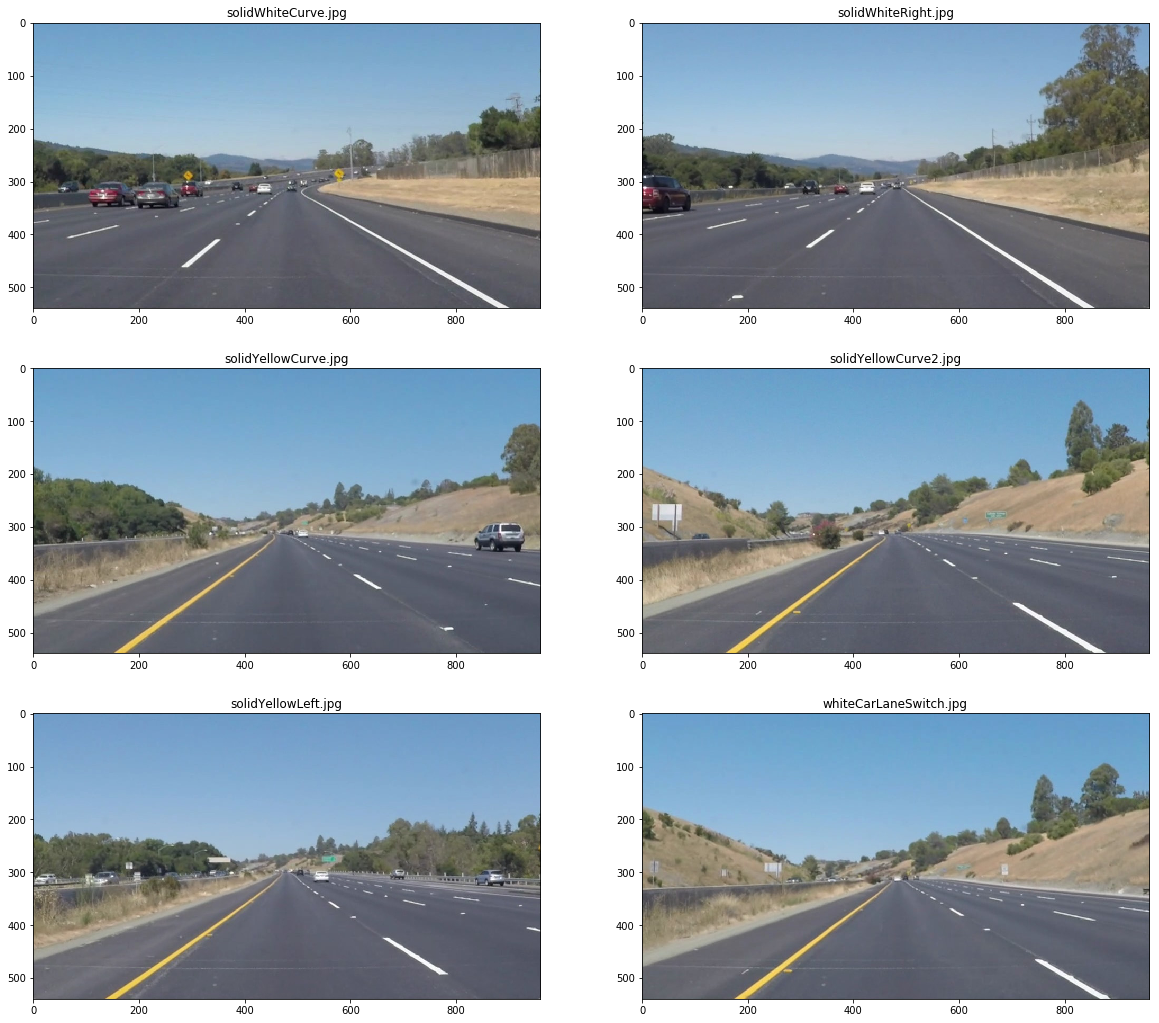

In [7]:
import os
test_set = []
test_files = []
test_folder = 'test_images/'
t = os.listdir(test_folder)
for i in range(0, len(t)):
    test_set.append(mpimg.imread(test_folder + t[i]))
    test_files.append(t[i])
    
plot_image_array(test_set, test_files)

## Conversion to grayscale and smoothing
We will start with a grayscale conversion to deal with different lane colors and a gaussian blur to reduce noise. The kernel_size should not be too high, otherwise narrow lane parts in the distance might disappear.


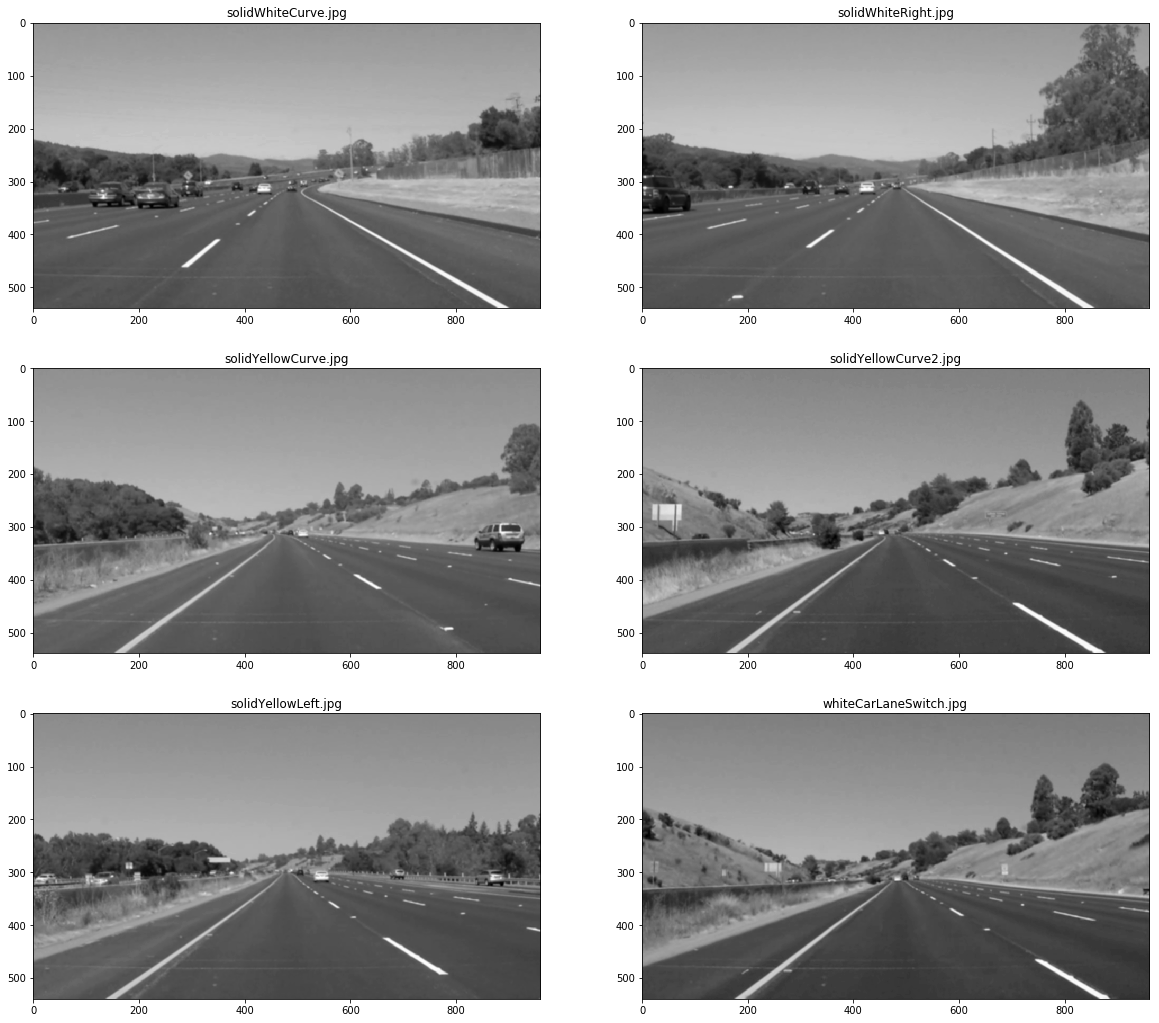

In [8]:
test_set_blurred = []
for img in test_set:
    test_set_blurred.append(gaussian_blur(grayscale(img), gauss_kernel_size))
    
plot_image_array(test_set_blurred, test_files)

## Edge detection
We will use a canny edge detection on the blurred images to find all significant edges in the image that might qualify as lane line.

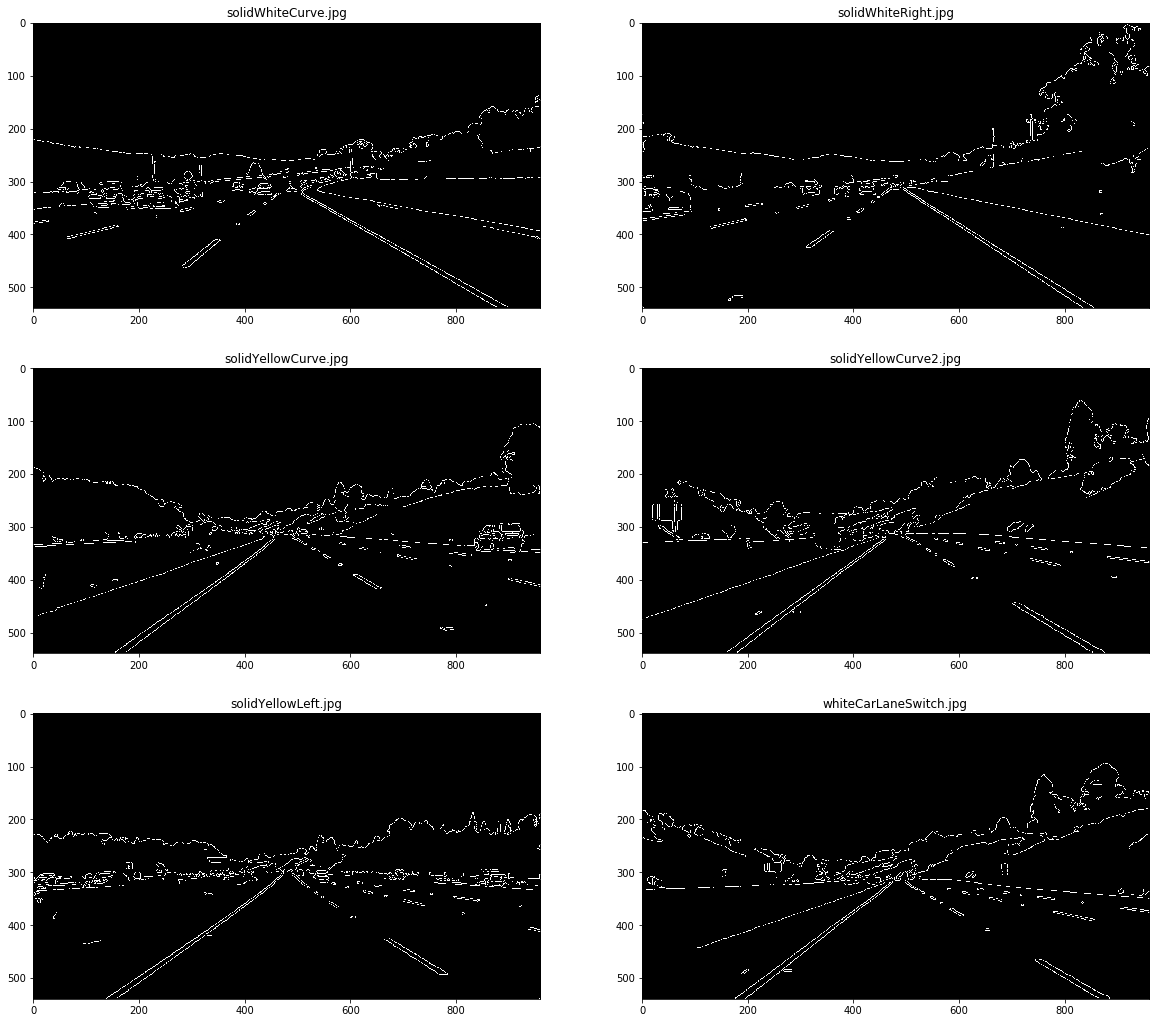

In [9]:
test_set_edges = []

for img in test_set_blurred:
    test_set_edges.append(canny(img, canny_t_low, canny_t_high))
    
plot_image_array(test_set_edges, test_files)

## Apply region of interest
We assume that the camere is positioned in the center of the car. The region in that we expect lane lines can be simplified to a trapezoid (acute or obtuse). The optimal shaping parameters depend in many variant factors like camera, landscape (hills), road (curves).

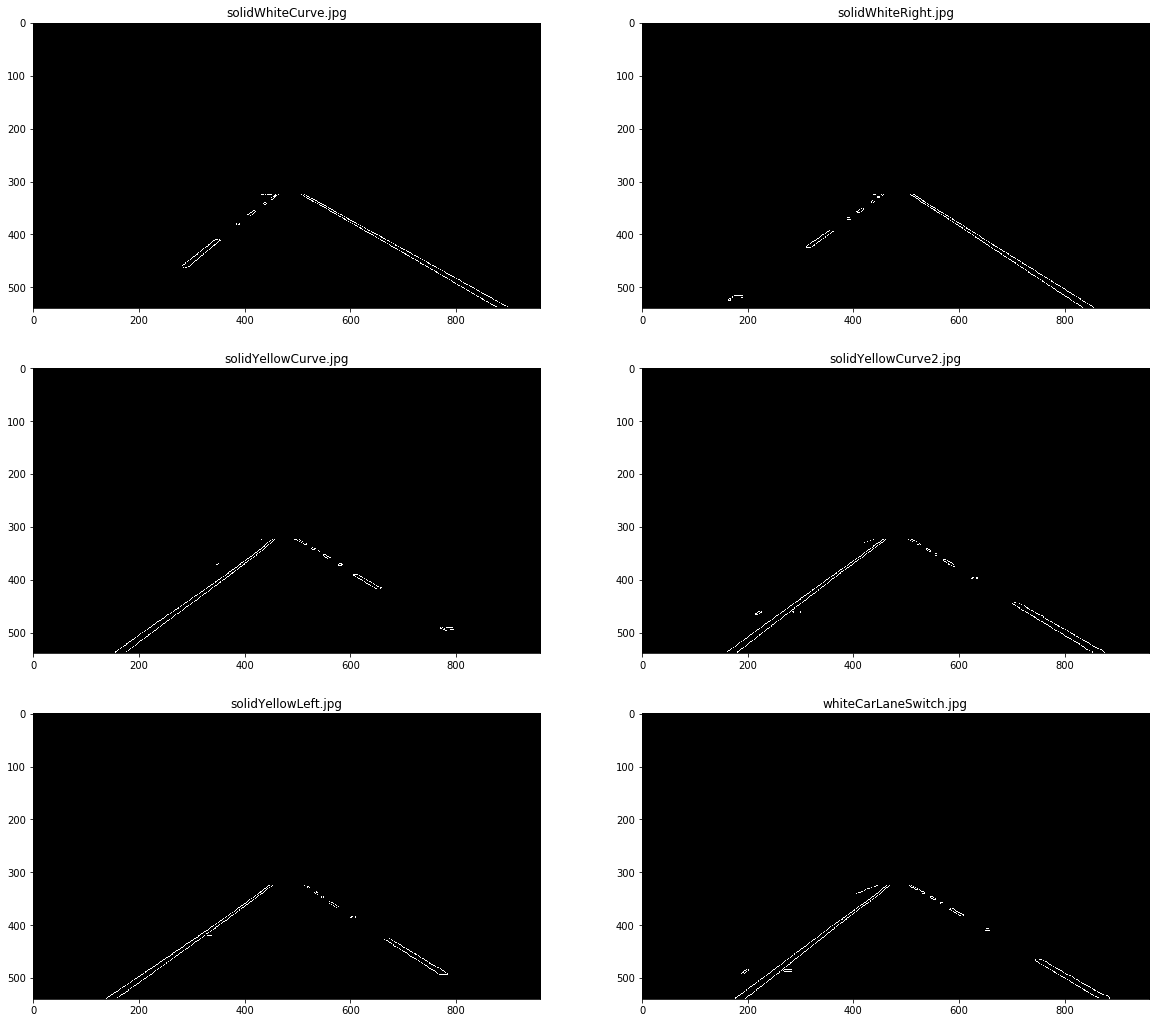

In [22]:

test_set_roi = []
for img in test_set_edges:
    imshape = img.shape
    vertices = np.array([[(roi_x_bot[0]*imshape[1], roi_y_bot[0]*imshape[0]),\
                      (roi_x_top[0]*imshape[1], roi_y_top[0]*imshape[0]),\
                      (roi_x_top[1]*imshape[1], roi_y_top[1]*imshape[0]),\
                      (roi_x_bot[1]*imshape[1], roi_y_bot[1]*imshape[0])]],\
                    dtype=np.int32)
    test_set_roi.append(region_of_interest(img, vertices))
    
plot_image_array(test_set_roi, test_files)

## Detect lines
Lines detected using Hough transformation and drawn onto the source image. 
* red: left lane
* green: right lane
* blue: discarded lines

To differ between lanes a histogram is calculated over the angles between a line and the y-axis weighted by the line length. The histogram is then split in the middle for left and right lane. The valid angle ranges for each lane are then extrated from the respective maximum bin and expanded around them.

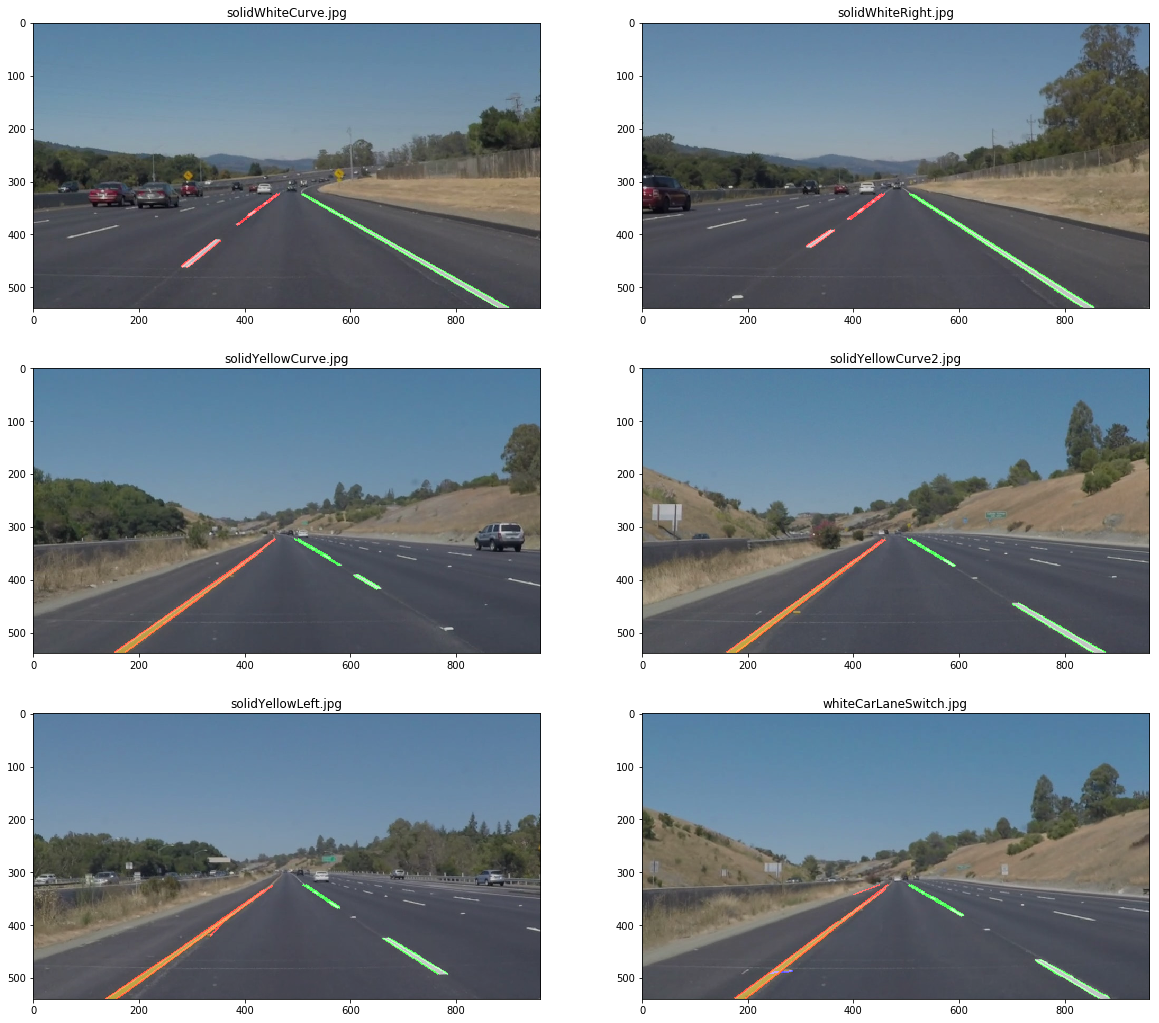

In [18]:

test_set_lines = []
for idx, img in enumerate(test_set_roi):
    try:
        lines = hough_lines(img, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap, 'lines')
        test_set_lines.append(weighted_img(lines, test_set[idx]))
    except ValueError as err:
        test_set_lines.append(test_set[idx])
        print(test_files[idx], err.args)

plot_image_array(test_set_lines, test_files)

## Draw Lane Lines
Use linear regression on the detected and categorized lines to extract a single line per lane.

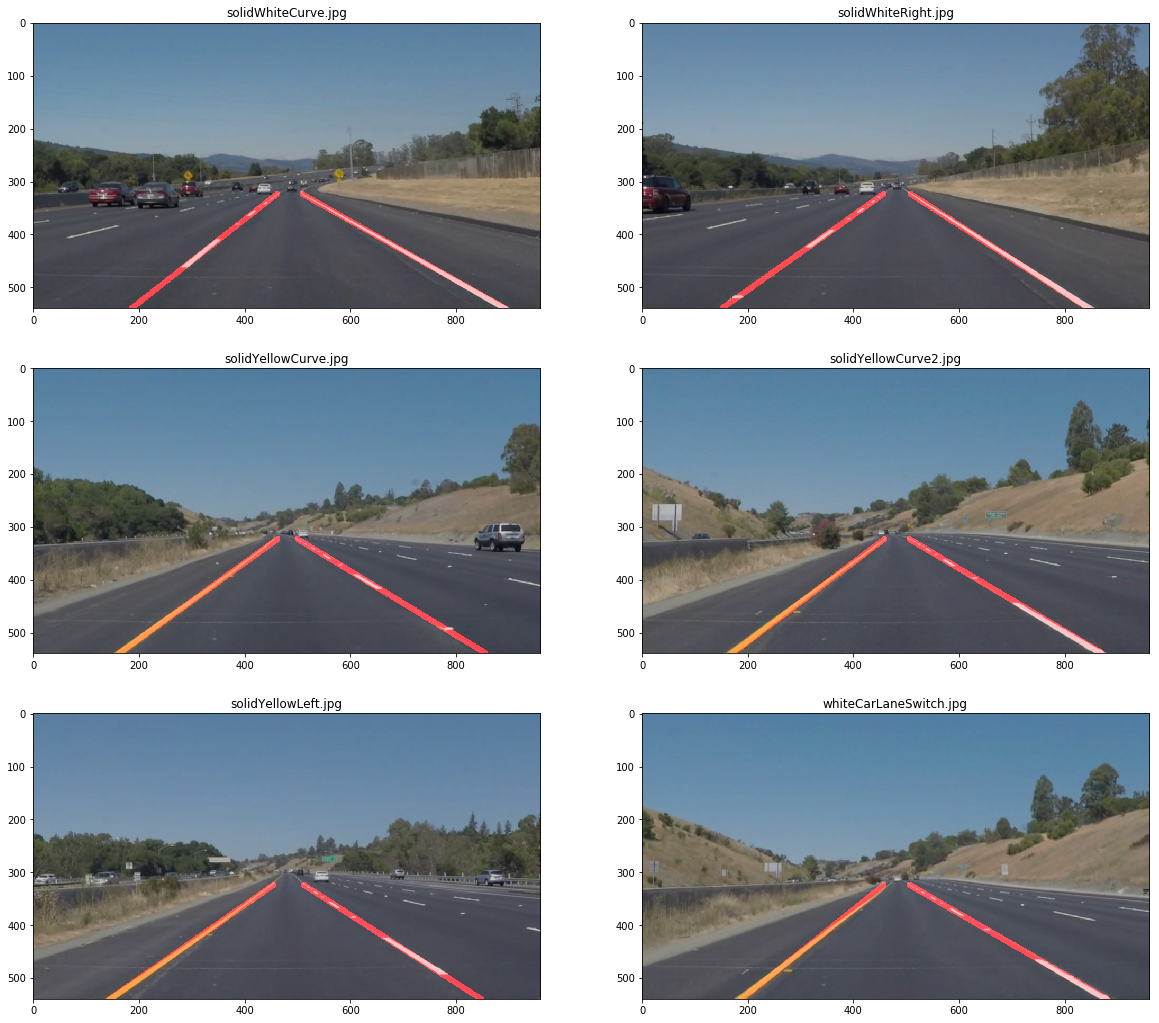

In [20]:
test_set_lines = []
for idx, img in enumerate(test_set_roi):
    try:
        lines = hough_lines(img, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap, 'lanes')
        test_set_lines.append(weighted_img(lines, test_set[idx]))
    except ValueError as err:
        test_set_lines.append(test_set[idx])
        print(test_files[idx], err.args)

plot_image_array(test_set_lines, test_files)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`



In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)  

    imshape = img.shape
    blurred = gaussian_blur(grayscale(img), gauss_kernel_size)
    edges = canny(blurred, canny_t_low, canny_t_high)

    vertices = np.array([[(roi_x_bot[0]*imshape[1], roi_y_bot[0]*imshape[0]),\
                      (roi_x_top[0]*imshape[1], roi_y_top[0]*imshape[0]),\
                      (roi_x_top[1]*imshape[1], roi_y_top[1]*imshape[0]),\
                      (roi_x_bot[1]*imshape[1], roi_y_bot[1]*imshape[0])]],\
                    dtype=np.int32)
    roi = region_of_interest(edges, vertices) 
    lines = img
    try:
        lines = hough_lines(roi, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap, 'lanes')
        
    # for frames that cause and exception we will save them for further debugging and parameter tuning
    except ValueError:
        save_image("debug_images/error" + str(process_image.img_counter) + ".jpg", img)
        process_image.img_counter += 1
        
    result = weighted_img(lines, img)
       
    return result

process_image.img_counter = 0

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:05<00:00, 35.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 6.82 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 30.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))